In [ ]:
!pip install stable_baselines3
!pip install 'shimmy>=0.2.1'
!pip install pygame


In [36]:
# Libraries
import matplotlib.pyplot as plt

from stable_baselines3 import PPO
import matplotlib.pyplot as plt

import gym
from gym import spaces
import numpy as np

from IPython.display import clear_output, display
import pygame


## **[1] Object Detection**
*   Location of fire
*   location of each drone



## **[2] Simultanoes Localization and Mapping**
* For observing obstacles

## **[3] Meta Agent Reinforcement Learning (Giving life to the system)**

**state space:**
* position of all drones
* position of fire
* position of obstacles
* battery status of all drones
* status of drone (heading to fire, heading to refuel, fighting fire)

**action space:**
* Position of where drone needs to end up



Defining Custom Environment

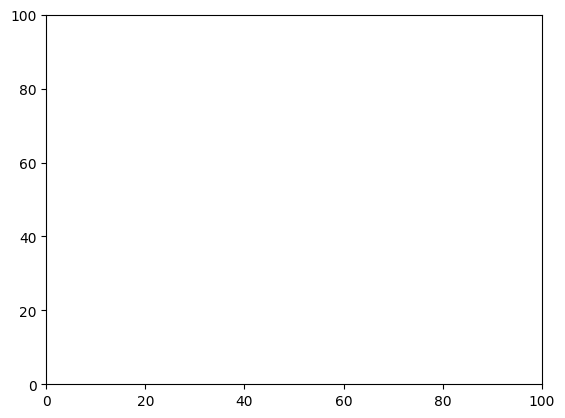

In [40]:


class CustomEnv(gym.Env):
    def __init__(self, num_drones, num_fires, num_obstacles):
        super(CustomEnv, self).__init__()

        # Define parameters
        self.num_drones = num_drones
        self.num_fires = num_fires
        self.num_obstacles = num_obstacles

        self.collision_radius = 1.0  # Collision radius for drones and obstacles
        self.extinguish_radius = 2.0 # Extinguish radius for fires
        self.fire_reward = 10.0      # Reward for extinguishing a fire

        # Define observation space (drone x, y, fire x, y, obstacle x, y)
        obs_low = np.zeros(2 * (num_drones + num_fires + num_obstacles))
        obs_high = np.ones(2 * (num_drones + num_fires + num_obstacles)) * 100  # Assuming 100x100 grid
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Define action space (dx, dy for each drone)
        action_low = np.ones(2 * num_drones) * -5
        action_high = np.ones(2 * num_drones) * 5
        self.action_space = spaces.Box(low=action_low, high=action_high, dtype=np.float32)

        # Initialize environment state
        self.state = np.zeros(2 * (num_drones + num_fires + num_obstacles))

        pygame.init()
        self.screen = pygame.display.set_mode((800, 600))
        pygame.display.set_caption('Drone Environment')
        self.clock = pygame.time.Clock()

    def reset(self):
        # Initialize the environment and return the initial observation
        self.state = np.random.uniform(0, 100, 2 * (self.num_drones + self.num_fires + self.num_obstacles))
        return self.state

    '''def step(self, action):
        # Apply action to the environment, update state
        # Here you would apply the physics of your drones and handle the obstacles and fires
        # This example just moves the drones according to the actions
        self.state[:2 * self.num_drones] += action

        # Check for collisions with obstacles or extinguishing fires
        # You would add more logic here based on the exact behavior of your drones, fires, and obstacles
        reward = 0
        for i in range(self.num_drones):
            drone_pos = self.state[2 * i:2 * i + 2]
            for j in range(self.num_fires):
                fire_pos = self.state[2 * (self.num_drones + j):2 * (self.num_drones + j + 1)]
                if np.linalg.norm(drone_pos - fire_pos) < 5:  # Assuming drones extinguish fires within distance 5
                    reward += 1'''


    def render(self, mode='human'):
        # Clear the current figure
        plt.clf()

        # Extract positions of drones, fires, and obstacles from the state
        drones_pos = self.state[:2 * self.num_drones].reshape(-1, 2)
        fires_pos = self.state[2 * self.num_drones:2 * (self.num_drones + self.num_fires)].reshape(-1, 2)
        obstacles_pos = self.state[2 * (self.num_drones + self.num_fires):].reshape(-1, 2)

        # Plot drones, fires, and obstacles
        plt.scatter(drones_pos[:, 0], drones_pos[:, 1], c='blue', label='Drones')
        plt.scatter(fires_pos[:, 0], fires_pos[:, 1], c='red', label='Fires')
        plt.scatter(obstacles_pos[:, 0], obstacles_pos[:, 1], c='black', label='Obstacles')

        plt.legend()
        plt.axis('equal')
        plt.pause(0.01)  # Add a pause to allow the plot to update

    def close(self):
        pygame.quit()

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.pause(0.01)  # Pause for a short period to allow the plot to update



    def step(self, action):
    # Extract the positions of drones, fires, and obstacles from the state
        drones_pos = self.state[:2 * self.num_drones].reshape(-1, 2)
        fires_pos = self.state[2 * self.num_drones:2 * (self.num_drones + self.num_fires)].reshape(-1, 2)
        obstacles_pos = self.state[2 * (self.num_drones + self.num_fires):].reshape(-1, 2)

    # Apply actions to drones (move them)
        for i in range(self.num_drones):
            drones_pos[i] += action[i * 2: (i + 1) * 2]

        # Check for collisions with obstacles and prevent them
            for obstacle_pos in obstacles_pos:
                if np.linalg.norm(drones_pos[i] - obstacle_pos) < self.collision_radius:
                # Logic to handle collision, e.g., stop the movement
                    drones_pos[i] -= action[i * 2: (i + 1) * 2]
    # Update the state with the new positions
        self.state[:2 * self.num_drones] = drones_pos.flatten()

    # Compute reward (e.g., based on extinguishing fires)
        reward = 0
        for i in range(self.num_fires):
            for j in range(self.num_drones):
                if np.linalg.norm(drones_pos[j] - fires_pos[i]) < self.extinguish_radius:
                    reward += self.fire_reward

    # Determine whether the episode is done (e.g., all fires are extinguished)
        done = False
        if reward == self.num_fires * self.fire_reward:
            done = True

    # Optional additional information
        info = {}

        return self.state, reward, done, info


        plt.xlim(0, 100)
        plt.ylim(0, 100)
        plt.pause(0.01)  # Pause for a short period to allow the plot to update


        # Set termination criteria
        done = False

        return self.state, reward, done, {}


**Creating and training PPO**

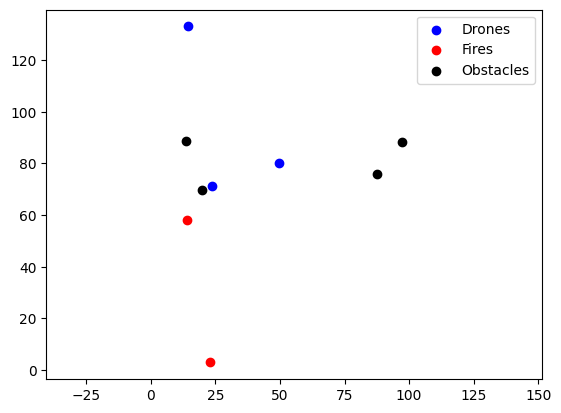

In [42]:
# Existing imports


# Existing environment definition
env = CustomEnv(num_drones=3, num_fires=2, num_obstacles=4)

# Create PPO model
model = PPO("MlpPolicy", env, verbose=1)

# Number of steps to train the model
total_timesteps = 10000

# Training loop with visualization
obs = env.reset()
'''for t in range(total_timesteps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    # Render the environment
    env.render()
    #plt.show()
    clear_output(wait=True)

    if done:
        obs = env.reset()'''
for t in range(total_timesteps):
    action, _ = model.predict(obs, deterministic=False)
    obs, reward, done, info = env.step(action)

    # Render the environment
    env.render()
    clear_output(wait=True)

    if done:
        obs = env.reset()

# Save the trained model
model.save("ppo_custom_env")

#plt.show()

env.close()


In [22]:
import gym
import numpy as np
import matplotlib.pyplot as plt

class CustomEnv(gym.Env):
    def __init__(self, num_drones=3, num_fires=2, num_obstacles=4):
        super(CustomEnv, self).__init__()

        self.num_drones = num_drones
        self.num_fires = num_fires
        self.num_obstacles = num_obstacles

        self.collision_radius = 1.0
        self.extinguish_radius = 2.0
        self.fire_reward = 10.0

        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(num_drones * 2,), dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(2 * (num_drones + num_fires + num_obstacles),), dtype=np.float32)

        self.state = np.concatenate([np.random.rand(num_drones, 2) * 100,
                                     np.random.rand(num_fires, 2) * 100,
                                     np.random.rand(num_obstacles, 2) * 100]).flatten()

    def step(self, action):
    # Extract the positions of drones, fires, and obstacles from the state
        drones_pos = self.state[:2 * self.num_drones].reshape(-1, 2)
        fires_pos = self.state[2 * self.num_drones:2 * (self.num_drones + self.num_fires)].reshape(-1, 2)
        obstacles_pos = self.state[2 * (self.num_drones + self.num_fires):].reshape(-1, 2)

    # Apply actions to drones (move them)
        for i in range(self.num_drones):
            drones_pos[i] += action[i * 2: (i + 1) * 2]

        # Check for collisions with obstacles and prevent them
            for obstacle_pos in obstacles_pos:
                if np.linalg.norm(drones_pos[i] - obstacle_pos) < self.collision_radius:
                # Logic to handle collision, e.g., stop the movement
                    drones_pos[i] -= action[i * 2: (i + 1) * 2]

    def reset(self):
        self.state = np.concatenate([np.random.rand(self.num_drones, 2) * 100,
                                     np.random.rand(self.num_fires, 2) * 100,
                                     np.random.rand(self.num_obstacles, 2) * 100]).flatten()
        return self.state

    def render(self, mode='human'):
        plt.clf()
        # ... same as previous code ...
        plt.pause(0.01)
        plt.show(block=False)

plt.ion()  # Turn on interactive mode

# Example of how to use the environment
env = CustomEnv()

for _ in range(1000):
    action = env.action_space.sample()  # Replace with your RL agent's action
    state, reward, done, _ = env.step(action)
    env.render()
    if done:
        env.reset()


TypeError: ignored

**Visualizing**

In [ ]:
import matplotlib.pyplot as plt

class CustomEnv(gym.Env):
    # Other methods...

    def render(self, mode='human'):
        # Clear the current figure
        plt.clf()

        # Extract positions of drones, fires, and obstacles from the state
        drones_pos = self.state[:2 * self.num_drones].reshape(-1, 2)
        fires_pos = self.state[2 * self.num_drones:2 * (self.num_drones + self.num_fires)].reshape(-1, 2)
        obstacles_pos = self.state[2 * (self.num_drones + self.num_fires):].reshape(-1, 2)

        # Plot drones, fires, and obstacles
        plt.scatter(drones_pos[:, 0], drones_pos[:, 1], c='blue', label='Drones')
        plt.scatter(fires_pos[:, 0], fires_pos[:, 1], c='red', label='Fires')
        plt.scatter(obstacles_pos[:, 0], obstacles_pos[:, 1], c='black', label='Obstacles')

        plt.legend()
        plt.axis('equal')
        plt.pause(0.01)  # Add a pause to allow the plot to update

# ...

env = CustomEnv()


In [ ]:
def render(self):
    plt.clf()

    # Plot drones
    for i in range(self.num_drones):
        drone_pos = self.state[2 * i:2 * i + 2]
        plt.scatter(drone_pos[0], drone_pos[1], c='blue')

    # Plot fires
    for i in range(self.num_fires):
        fire_pos = self.state[2 * (self.num_drones + i):2 * (self.num_drones + i + 1)]
        plt.scatter(fire_pos[0], fire_pos[1], c='red')

    # Plot obstacles
    for i in range(self.num_obstacles):
        obstacle_pos = self.state[2 * (self.num_drones + self.num_fires + i):2 * (self.num_drones + self.num_fires + i + 1)]
        plt.scatter(obstacle_pos[0], obstacle_pos[1], c='black')

    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.pause(0.01)  # Pause for a short period to allow the plot to update


## **[4] Path Planning**
* Multi Agent Path Planning Algorithm
* https://github.com/atb033/multi_agent_path_planning

## **[5] Environment Creation**

1. Fly mother drone to fixed height
2.  Creating an abstract representation of the environment involves processing the raw sensor data and extracting the information relevant to the task. Here's a general process you might follow:

1. **Use Object Detection on Video Frames:** Using the video feed from the mother drone, apply object detection algorithms to identify the smaller drones, fires, and obstacles. This could involve training a convolutional neural network (CNN) on labeled images of these objects.

    If you're using OAK-D Lite, it already comes with built-in capabilities for object detection, making this process easier.

2. **Coordinate Estimation:** Once the objects are detected in each frame, estimate their coordinates. In your case, since the mother drone is looking from above, the 2D image coordinates can be converted to real-world coordinates with some geometric transformation considering the height of the mother drone and camera angle.

3. **Construct State Vector:** The RL agent's state could be a vector containing the 2D coordinates of all identified objects (smaller drones, fires, obstacles). Remember to standardize the coordinate data for more efficient learning.

For example, if there are 2 drones (D1, D2), 1 fire (F1), and 1 obstacle (O1), a state vector might look something like this:

```
State = [D1_x, D1_y, D2_x, D2_y, F1_x, F1_y, O1_x, O1_y]
```

In this vector, `D1_x` and `D1_y` would be the x and y coordinates of drone D1, and so on for the other objects.

4. **Update State:** As the mother drone gets new video frames, update the state vector in real-time. This updated state is then passed to the RL agent to choose the next action.

This abstract representation of the environment greatly simplifies the state space and reduces the computational resources needed by the RL algorithm, while still retaining the necessary information for the task. However, it does rely on accurate object detection and coordinate estimation to construct the state vector.

## **[6] Communication between drones**

* MAVLink
* WIFI
